<a href="https://colab.research.google.com/github/rajensalim/nsfw_filter/blob/main/nudity_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install kaggle

In [ ]:
! mkdir ~/.kaggle

In [ ]:
#to upload kaggle.json file through drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#copy kaggle.json from drive to colab
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json


In [ ]:
# ! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
import tensorflow as tf
import os
import zipfile
import matplotlib.pyplot as plt
import numpy as np
import warnings
import random
import shutil
from PIL import Image
from shutil import copyfile
from google.colab import files
from keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
Image.MAX_IMAGE_PIXELS = None
warnings.simplefilter('error', Image.DecompressionBombWarning)

In [ ]:
# download dataset
! kaggle datasets download drakedtrex/my-nsfw-dataset

 97% 631M/652M [00:03<00:00, 165MB/s]
100% 652M/652M [00:03<00:00, 192MB/s]


In [ ]:
# initiate base model, input shape, dan exclude last layer
pre_trained_model = InceptionV3(input_shape = (300, 300, 3), 
                                include_top = False, 
                                weights = 'imagenet')

87924736/87910968 [==============================] - 1s 0us/step


In [ ]:
pre_trained_model.summary()

In [ ]:
# choose mixed8 as base model
last_layer = pre_trained_model.get_layer('mixed8')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 8, 8, 1280)


In [ ]:
# flatten layer to 1 dimension
x = layers.Flatten()(last_output)
# add connected layer
x = layers.Dense(1024, activation='relu')(x)
# add a dropout layer
x = layers.Dropout(0.2)(x)                  
# add final for clasification, for this case we use binary classification
x = layers.Dense  (1, activation='sigmoid')(x)           

# Append the dense network to the base model
model = Model(pre_trained_model.input, x) 

# Print the model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 300, 300, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

# Data

In [ ]:
# Extract the archive
zip_ref = zipfile.ZipFile("./my-nsfw-dataset.zip", 'r')
zip_ref.extractall("/tmp/file_nudity")
zip_ref.close()

source_path = '/tmp/file_nudity'
source_path_NSFW = os.path.join(source_path, 'train/train/NSFW')
source_path_SFW = os.path.join(source_path, 'train/train/SFW')


# os.listdir returns a list containing all files under the given path
print(f"There are {len(os.listdir(source_path_NSFW))} images of NSFW.")
print(f"There are {len(os.listdir(source_path_SFW))} images of SFW.")

There are 738 images of NSFW.
There are 738 images of SFW.


In [ ]:
# Create and define our example directories and files
base_dir = '/tmp/split_file'
os.mkdir(base_dir)


In [ ]:
# Empty directory to prevent FileExistsError is the function is run several times
#create path for train and validation
def create_train_test_dirs(base_path):
  train_dir = os.path.join(base_dir, 'train')
  os.mkdir(train_dir)
  val_dir = os.path.join(base_dir, 'validation')
  os.mkdir(val_dir)

  # Directory with training NSFW pictures
  train_nsfw_dir = os.path.join(train_dir, 'NSFW')
  os.mkdir(train_nsfw_dir)
  # Directory with training SFW pictures
  train_sfw_dir = os.path.join(train_dir, 'SFW')
  os.mkdir(train_sfw_dir)

  # Directory with validation NSFW pictures
  validation_nsfw_dir = os.path.join(val_dir, 'NSFW')
  os.mkdir(validation_nsfw_dir)
  # Directory with validation SFW pictures
  validation_sfw_dir = os.path.join(val_dir, 'SFW')
  os.mkdir(validation_sfw_dir)
  
  pass

try:
  create_train_test_dirs(base_path=base_dir)
except FileExistsError:
  print("You should not be seeing this since the upper directory is removed beforehand")

In [ ]:
def split_data(SOURCE, TRAINING, VALIDATION, SPLIT_SIZE):

  files = []
  for filename in os.listdir(SOURCE):
    file = SOURCE + filename
    if os.path.getsize(file) > 0:
      files.append(filename)
    else:
      print(filename + ' is zero length, so ignoring.')

    training_length = int(len(files) * SPLIT_SIZE)
    validation_length = int(len(files) - training_length)
    shuffled_set = random.sample(files, len(files))
    training_set = shuffled_set[0:training_length]
    validation_set = shuffled_set[-validation_length:]
  
  for filename in training_set:
    src_file = SOURCE + filename
    dest_file = TRAINING + filename
    copyfile(src_file, dest_file)
    
  for filename in validation_set:
    src_file = SOURCE + filename
    dest_file = VALIDATION + filename
    copyfile(src_file, dest_file)
  pass

In [ ]:
NSFW_SOURCE_DIR = "/tmp/file_nudity/train/train/NSFW/"
SFW_SOURCE_DIR = "/tmp/file_nudity/train/train/SFW/"

TRAINING_DIR = "/tmp/split_file/train/"
VALIDATION_DIR = "/tmp/split_file/validation/"

TRAINING_NSFW_DIR = os.path.join(TRAINING_DIR, "NSFW/")
VALIDATION_NSFW_DIR = os.path.join(VALIDATION_DIR, "NSFW/")

TRAINING_SFW_DIR = os.path.join(TRAINING_DIR, "SFW/")
VALIDATION_SFW_DIR = os.path.join(VALIDATION_DIR, "SFW/")

# Empty directories in case you run this cell multiple times
if len(os.listdir(TRAINING_NSFW_DIR)) > 0:
  for file in os.scandir(TRAINING_NSFW_DIR):
    os.remove(file.path)
if len(os.listdir(TRAINING_SFW_DIR)) > 0:
  for file in os.scandir(TRAINING_SFW_DIR):
    os.remove(file.path)
if len(os.listdir(VALIDATION_NSFW_DIR)) > 0:
  for file in os.scandir(VALIDATION_NSFW_DIR):
    os.remove(file.path)
if len(os.listdir(VALIDATION_SFW_DIR)) > 0:
  for file in os.scandir(VALIDATION_SFW_DIR):
    os.remove(file.path)

# Define proportion of images used for training
split_size = .75

# Run the function
# NOTE: Messages about zero length images should be printed out
split_data(NSFW_SOURCE_DIR, TRAINING_NSFW_DIR, VALIDATION_NSFW_DIR, split_size)
split_data(SFW_SOURCE_DIR, TRAINING_SFW_DIR, VALIDATION_SFW_DIR, split_size)

# Check that the number of images matches the expected output
print(f"\n\nThere are {len(os.listdir(TRAINING_NSFW_DIR))} images of NSFW for training")
print(f"There are {len(os.listdir(TRAINING_SFW_DIR))} images of SFW for training")
print(f"There are {len(os.listdir(VALIDATION_NSFW_DIR))} images of NSFW for validation")
print(f"There are {len(os.listdir(VALIDATION_NSFW_DIR))} images of SFW for validation")



There are 553 images of NSFW for training
There are 553 images of SFW for training
There are 185 images of NSFW for validation
There are 185 images of SFW for validation


In [ ]:
# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# Note that the validation data should not be augmented!
validation_datagen = ImageDataGenerator( rescale = 1.0/255. )

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    batch_size = 14,
                                                    class_mode = 'binary', 
                                                    target_size = (300, 300))     

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  validation_datagen.flow_from_directory( VALIDATION_DIR,
                                                          batch_size  = 10,
                                                          class_mode  = 'binary', 
                                                          target_size = (300, 300))

Found 1106 images belonging to 2 classes.
Found 370 images belonging to 2 classes.


# Tuning Learning Rate

In [ ]:
# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

# Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)

# Train the model
history = model.fit(train_generator, epochs=100, callbacks=[lr_schedule])

In [ ]:
# Define the learning rate array
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-8, 1e-3, 0, 0.2])

# Train the Model

In [ ]:
# Set the training parameters
lr=0.0001
model.compile(optimizer = RMSprop(learning_rate=lr), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])

In [ ]:
# Train the model.
history = model.fit(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 50,
            epochs = 50,
            validation_steps = 10)

Epoch 1/50
50/50 [==============================] - 65s 848ms/step - loss: 1.1242 - accuracy: 0.7643 - val_loss: 0.3891 - val_accuracy: 0.9000
Epoch 2/50
50/50 [==============================] - 41s 814ms/step - loss: 0.2529 - accuracy: 0.9114 - val_loss: 0.6312 - val_accuracy: 0.8900
Epoch 3/50
50/50 [==============================] - 42s 846ms/step - loss: 0.2113 - accuracy: 0.9257 - val_loss: 0.1791 - val_accuracy: 0.9500
Epoch 4/50
50/50 [==============================] - 40s 800ms/step - loss: 0.1647 - accuracy: 0.9457 - val_loss: 1.2166 - val_accuracy: 0.9000
Epoch 5/50
50/50 [==============================] - 41s 821ms/step - loss: 0.1960 - accuracy: 0.9300 - val_loss: 0.3047 - val_accuracy: 0.9300
Epoch 6/50
50/50 [==============================] - 42s 836ms/step - loss: 0.1404 - accuracy: 0.9543 - val_loss: 1.0810 - val_accuracy: 0.9300
Epoch 7/50
50/50 [==============================] - 41s 805ms/step - loss: 0.1050 - accuracy: 0.9729 - val_loss: 2.6186 - val_accuracy: 0.8300

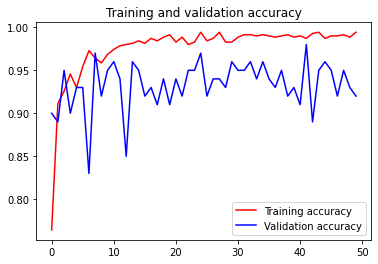

<Figure size 432x288 with 0 Axes>

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

In [ ]:
from google.colab import files
from keras.preprocessing import image

uploaded=files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path=fn
  img=image.load_img(path, target_size=(300, 300))
  
  x=image.img_to_array(img)
  x /= 255
  x=np.expand_dims(x, axis=0)
  images = np.vstack([x])
  
  classes = model.predict(images, batch_size=10)
  
  print(classes)
  
  if classes<0.5:
    print(fn + " is inappropriate")
  else:
    print(fn + " is safe")

Saving NSFW (10).jpg to NSFW (10).jpg
Saving NSFW (11).jpg to NSFW (11).jpg
Saving NSFW (12).jpg to NSFW (12).jpg
Saving NSFW (13).jpg to NSFW (13).jpg
Saving NSFW (14).jpg to NSFW (14).jpg
Saving NSFW (15).jpg to NSFW (15).jpg
Saving NSFW (16).jpg to NSFW (16).jpg
Saving NSFW (17).jpg to NSFW (17).jpg
Saving NSFW (18).jpg to NSFW (18).jpg
Saving NSFW (19).jpg to NSFW (19).jpg
Saving SFW (30).jpg to SFW (30).jpg
Saving SFW (31).jpg to SFW (31).jpg
Saving SFW (32).jpg to SFW (32).jpg
Saving SFW (33).jpg to SFW (33).jpg
Saving SFW (34).jpg to SFW (34).jpg
Saving SFW (35).jpg to SFW (35).jpg
Saving SFW (36).jpg to SFW (36).jpg
Saving SFW (37).jpg to SFW (37).jpg
Saving SFW (38).jpg to SFW (38).jpg
Saving SFW (39).jpg to SFW (39).jpg
[[6.483645e-09]]
NSFW (10).jpg is inappropriate
[[0.]]
NSFW (11).jpg is inappropriate
[[5.7083533e-25]]
NSFW (12).jpg is inappropriate
[[3.006548e-10]]
NSFW (13).jpg is inappropriate
[[2.4416797e-35]]
NSFW (14).jpg is inappropriate
[[0.]]
NSFW (15).jpg is inap